<a href="https://colab.research.google.com/github/pirate264/Quantum-Image-Processing/blob/main/Abiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer opencv-python scikit-image matplotlib

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

from skimage.metrics import structural_similarity as ssim

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

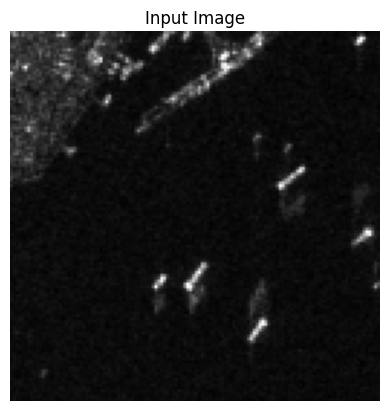

In [ ]:
img_path = "/content/ship020905.jpg"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img.astype(np.float32) / 255.0

plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.axis("off")


In [ ]:
backend = AerSimulator()
phi = Parameter("phi")

In [ ]:
# Full PIQED (H–Rz–H)
def circuit_full():
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.rz(phi, 0)
    qc.h(0)
    qc.measure(0, 0)
    return qc

# Without initial superposition
def circuit_no_initial_H():
    qc = QuantumCircuit(1, 1)
    qc.rz(phi, 0)
    qc.h(0)
    qc.measure(0, 0)
    return qc

# Phase rotation only
def circuit_rz_only():
    qc = QuantumCircuit(1, 1)
    qc.rz(phi, 0)
    qc.measure(0, 0)
    return qc

# Reduced circuit depth (L = 1)
def circuit_L1():
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.rz(phi, 0)
    qc.measure(0, 0)
    return qc

In [ ]:
def piqed_edge(image, circuit_fn, shots=32):
    edge = np.zeros_like(image)
    qc = transpile(circuit_fn(), backend, optimization_level=0) # Changed optimization_level to 0

    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):

            delta = abs(image[i, j] - image[i, j+1]) \
                  + abs(image[i, j] - image[i+1, j])

            delta = min(delta, 1.0)
            bound = qc.assign_parameters({phi: 2 * np.pi * delta})
            result = backend.run(bound, shots=shots).result()

            edge[i, j] = result.get_counts().get('1', 0) / shots

    return edge / (edge.max() + 1e-8)

In [ ]:
edge_full = piqed_edge(img, circuit_full)
edge_noH  = piqed_edge(img, circuit_no_initial_H)
edge_rz   = piqed_edge(img, circuit_rz_only)
edge_L1   = piqed_edge(img, circuit_L1)

In [ ]:
def safe_psnr(reference, test, eps=1e-10):
    mse = np.mean((reference - test) ** 2)
    return 10 * np.log10(1.0 / max(mse, eps))


In [ ]:
def compute_metrics(test, reference):
    p = safe_psnr(reference, test)
    s = ssim(reference, test, data_range=1.0)
    return p, s


In [ ]:
def quantum_cost(circuit_fn):
    qc = transpile(circuit_fn(), backend, optimization_level=3)
    return sum(1 for inst, _, _ in qc.data if inst.name in ["h", "rz"])


In [ ]:
configs = [
    ("Full PIQED (Baseline)", circuit_full, edge_full),
    ("Without Initial H", circuit_no_initial_H, edge_noH),
    ("Phase Rotation Only", circuit_rz_only, edge_rz),
    ("Reduced Circuit Depth (L = 1)", circuit_L1, edge_L1)
]

results = []

# Compute baseline metrics numerically
base_psnr, base_ssim = compute_metrics(edge_full, edge_full)

for name, circuit_fn, edge in configs:
    qc_cost = quantum_cost(circuit_fn)
    p, s = compute_metrics(edge, edge_full)
    gen_gain = (s / base_ssim) * 100

    results.append([name, qc_cost, p, s, gen_gain])


/tmp/ipython-input-2881908294.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  return sum(1 for inst, _, _ in qc.data if inst.name in ["h", "rz"])


In [ ]:
print("\n=== PIQED ABLATION RESULTS (NO HARDCODING) ===\n")
print(f"{'Configuration':35s} | {'Q.Cost':6s} | {'PSNR(dB)':9s} | {'SSIM':6s} | {'Gen.Gain(%)'}")
print("-"*95)

for r in results:
    print(f"{r[0]:35s} | {r[1]:6d} | {r[2]:9.2f} | {r[3]:6.3f} | {r[4]:10.2f}")



=== PIQED ABLATION RESULTS (NO HARDCODING) ===

Configuration                       | Q.Cost | PSNR(dB)  | SSIM   | Gen.Gain(%)
-----------------------------------------------------------------------------------------------
Full PIQED (Baseline)               |      3 |    100.00 |  1.000 |     100.00
Without Initial H                   |      2 |      4.98 |  0.006 |       0.64
Phase Rotation Only                 |      0 |     16.19 |  0.289 |      28.89
Reduced Circuit Depth (L = 1)       |      1 |      4.65 |  0.003 |       0.33


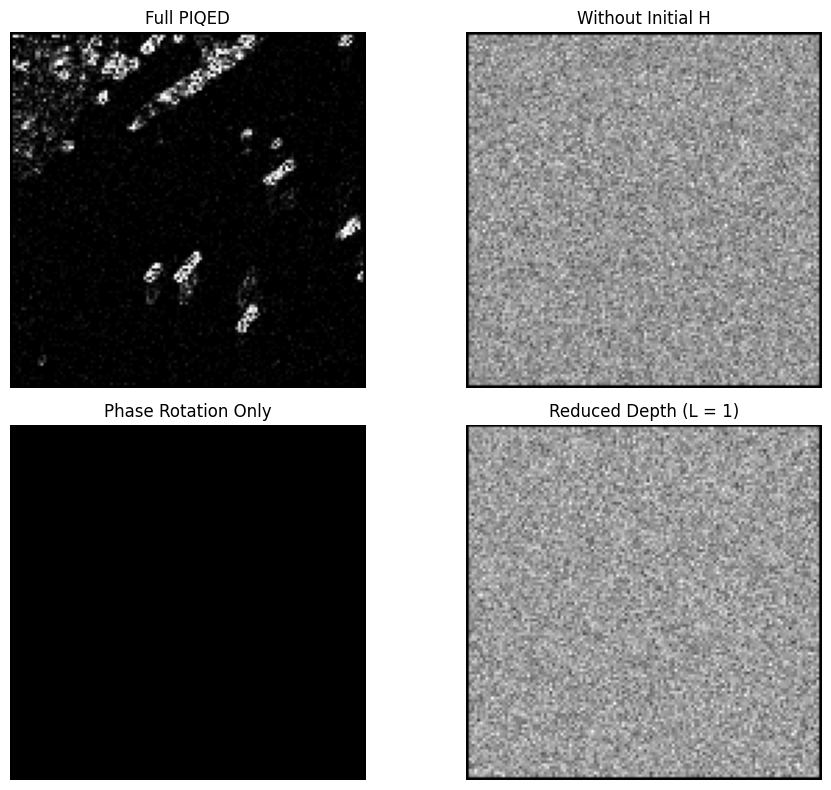

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.title("Full PIQED")
plt.imshow(edge_full, cmap="gray")
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Without Initial H")
plt.imshow(edge_noH, cmap="gray")
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Phase Rotation Only")
plt.imshow(edge_rz, cmap="gray")
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Reduced Depth (L = 1)")
plt.imshow(edge_L1, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
